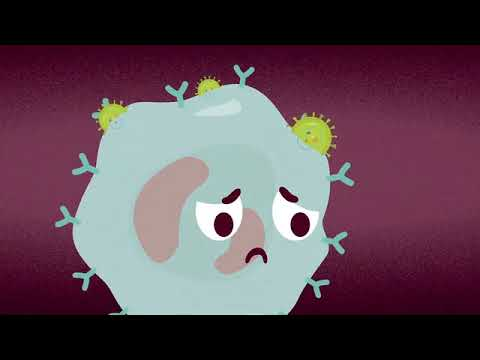

In [1]:
from IPython.display import display, YouTubeVideo
YouTubeVideo('cSNaBui2IM8')

In [2]:
from qiskit import Aer

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter

from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.algorithms import GroundStateEigensolver, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver

from qiskit.utils import QuantumInstance

from qiskit_nature.circuit.library.ansatzes import UCCSD
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit.circuit.library import TwoLocal

from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import COBYLA

from functools import partial as apply_variation_to_atom_pair
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.8/site-packages/pyscf/lib/misc.py:47: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [3]:
hydrogen_molecule = Molecule(geometry=
                             [['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

In [4]:
molecular_hydrogen_orbital_maker = PySCFDriver(molecule=hydrogen_molecule, unit=UnitsType.ANGSTROM, basis='sto3g')
split_into_classical_and_quantum = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)

In [5]:
hydrogen_fermionic_hamiltonian = ElectronicStructureProblem(molecular_hydrogen_orbital_maker)

In [6]:
hydrogen_fermionic_hamiltonian.second_q_ops()
print("Completed running classical package.\nFermionic molecular-orbital Hamiltonian calculated and stored internally.")
print("An example of HF info available: Orbital Energies", hydrogen_fermionic_hamiltonian._molecule_data_transformed.orbital_energies)

Completed running classical package.
Fermionic molecular-orbital Hamiltonian calculated and stored internally.
An example of HF info available: Orbital Energies [-0.58062892  0.67633625]


In [7]:
map_fermions_to_qubits = QubitConverter(JordanWignerMapper())
# e.g. alternative:
# map_fermions_to_qubits = QubitConverter(BravyiKitaevMapper())

In [8]:
hydrogen_molecule_info          = hydrogen_fermionic_hamiltonian.molecule_data_transformed
num_hydrogen_molecular_orbitals = hydrogen_molecule_info.num_molecular_orbitals
num_hydrogen_spin_orbitals      = 2 * num_hydrogen_molecular_orbitals

In [9]:
num_hydrogen_electrons_spin_up_spin_down = (hydrogen_molecule_info.num_alpha, hydrogen_molecule_info.num_beta)

In [10]:
hydrogen_molecule_info          = hydrogen_fermionic_hamiltonian.molecule_data_transformed
num_hydrogen_molecular_orbitals = hydrogen_molecule_info.num_molecular_orbitals
num_hydrogen_spin_orbitals      = 2 * num_hydrogen_molecular_orbitals

In [11]:
num_hydrogen_electrons_spin_up_spin_down = (hydrogen_molecule_info.num_alpha, hydrogen_molecule_info.num_beta)

In [12]:
hydrogen_initial_state = HartreeFock(num_hydrogen_spin_orbitals,
                                     num_hydrogen_electrons_spin_up_spin_down,
                                     map_fermions_to_qubits)

In [13]:
hydrogen_chemistry_inspired_trial = UCCSD(map_fermions_to_qubits,
                                          num_hydrogen_electrons_spin_up_spin_down,
                                          num_hydrogen_spin_orbitals,
                                          initial_state=hydrogen_initial_state)

In [14]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

In [15]:
hydrogen_trial_state = hydrogen_chemistry_inspired_trial
# OR
# hydrogen_trial_state = hardware_inspired_trial

In [16]:
noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [17]:
hydrogen_vqe_solver = VQE(ansatz=hydrogen_trial_state, quantum_instance=noise_free_quantum_environment)

In [18]:
hydrogen_ground_state = GroundStateEigensolver(map_fermions_to_qubits, hydrogen_vqe_solver)

In [19]:
hydrogen_ground_state_info = hydrogen_ground_state.solve(hydrogen_fermionic_hamiltonian)

print(hydrogen_ground_state_info)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894841]
    - computed part:      [0.0  0.0  1.38894841]
  > Dipole moment (a.u.): [0.0  0.0  0.00000029]  Total: 0.00000029
                 (debye): [0.0  0.0  0.00000074]  Total: 0.00000074
 


In [20]:
#Alternative Step 3b
numpy_solver = NumPyMinimumEigensolver()

#Alternative Step 4
ground_state_classical = GroundStateEigensolver(map_fermions_to_qubits, numpy_solver)
hydrogen_ground_state_info_classical = ground_state_classical.solve(hydrogen_fermionic_hamiltonian)

hydrogen_energy_classical = hydrogen_ground_state_info.computed_energies[0]
print("Ground-state electronic energy (via classical calculations): ", hydrogen_energy_classical, "Hartree")

Ground-state electronic energy (via classical calculations):  -1.857275030145182 Hartree


In [21]:
molecular_variation = Molecule.absolute_stretching

#Other types of molecular variation:
#molecular_variation = Molecule.relative_stretching
#molecular_variation = Molecule.absolute_bending
#molecular_variation = Molecule.relative_bending

In [22]:
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(1, 0))

In [23]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])

In [24]:
hydrogen_molecule_stretchable.perturbations = [0.1]

In [25]:
hydrogen_molecule_stretchable.geometry

[['H', [0.0, 0.0, 0.0]], ('H', [0.0, 0.0, 0.835])]

In [26]:
specific_molecular_variation = apply_variation_to_atom_pair(molecular_variation, atom_pair=(3, 2))

In [27]:
macromolecule = Molecule(geometry=
                         [['O',[1.1280, 0.2091, 0.0000]],
                          ['C',[0.0598, -0.3882, 0.0000]],
                          ['N',[-1.1878, 0.1791, 0.0000]],
                          ['C',[-0.1805, 1.3955, 0.0000]],
                          ['H',[-1.3085, 1.1864, 0.0001]],
                          ['H',[-2.0305, -0.3861, -0.0001]],
                          ['H',[-0.0014, -1.4883, -0.0001]]],
                          charge=0,multiplicity=1,
                          degrees_of_freedom=[specific_molecular_variation])

In [28]:
from qc_grader import grade_ex3a

grade_ex3a(molecule=macromolecule)

Submitting your answer for ex3/partA. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [29]:
from qc_grader import grade_ex3b

## Q1
#answer_for_ex3b_q1 = 'A'
#answer_for_ex3b_q1 = 'B'
answer_for_ex3b_q1 = 'C'
##
answer_for_ex3b_q1 = 'C'
## Q2
answer_for_ex3b_q2 = 'A'
#answer_for_ex3b_q2 = 'B'
#answer_for_ex3b_q2 = 'C'
#answer_for_ex3b_q2 = 'D'
##
answer_for_ex3b_q2 = 'A'

grade_ex3b(answer_for_ex3b_q1, answer_for_ex3b_q2)

Submitting your answer for ex3/partB. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [30]:
hydrogen_stretchable_molecular_orbital_maker = PySCFDriver(molecule=hydrogen_molecule_stretchable, unit=UnitsType.ANGSTROM, basis='sto3g')
split_into_classical_and_quantum = ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
hydrogen_stretchable_fermionic_hamiltonian = ElectronicStructureProblem(hydrogen_stretchable_molecular_orbital_maker)

In [31]:
energy_surface = BOPESSampler(gss=hydrogen_ground_state, bootstrap=False) # same solver suffices, since the trial is the same
perturbation_steps = np.linspace(-0.5, 2, 25) # 25 equally spaced points from -0.5 to 2, inclusive.

energy_surface_result = energy_surface.sample(hydrogen_stretchable_fermionic_hamiltonian, perturbation_steps)

/opt/conda/lib/python3.8/site-packages/qiskit_nature/algorithms/pes_samplers/bopes_sampler.py:192: DeprecationWarning: 
The VQE.optimal_params property is deprecated as of Qiskit Terra 0.18.0
and will be removed no sooner than 3 months after the releasedate.
This information is part of the returned result object and can be
queried as VQEResult.optimal_point.
  optimal_params = self._gss.solver.optimal_params  # type: ignore


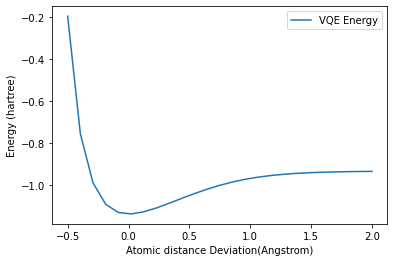

In [32]:
def plot_energy_landscape(energy_surface_result):
    if len(energy_surface_result.points) > 1:
        plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
        plt.xlabel('Atomic distance Deviation(Angstrom)')
        plt.ylabel('Energy (hartree)')
        plt.legend()
        plt.show()
    else:
        print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
        print("(No need to plot, only one configuration calculated.)")
    
plot_energy_landscape(energy_surface_result)

In [33]:
def construct_hamiltonian_solve_ground_state(
    molecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    hardware_inspired_trial=None,
    vqe=True,
    perturbation_steps=np.linspace(-1, 1, 3),
):
    """Creates fermionic Hamiltonion and solves for the energy surface.

    Args:
        molecule (Union[qiskit_nature.drivers.molecule.Molecule, NoneType]): The molecule to simulate.
        num_electrons (int, optional): Number of electrons for the `ActiveSpaceTransformer`. Defaults to 2.
        num_molecular_orbitals (int, optional): Number of electron orbitals for the `ActiveSpaceTransformer`. Defaults to 2.
        chemistry_inspired (bool, optional): Whether to create a chemistry inspired trial state. `hardware_inspired_trial` must be `None` when used. Defaults to True.
        hardware_inspired_trial (QuantumCircuit, optional): The hardware inspired trial state to use. `chemistry_inspired` must be False when used. Defaults to None.
        vqe (bool, optional): Whether to use VQE to calculate the energy surface. Uses `NumPyMinimumEigensolver if False. Defaults to True.
        perturbation_steps (Union(list,numpy.ndarray), optional): The points along the degrees of freedom to evaluate, in this case a distance in angstroms. Defaults to np.linspace(-1, 1, 3).

    Raises:
        RuntimeError: `chemistry_inspired` and `hardware_inspired_trial` cannot be used together. Either `chemistry_inspired` is False or `hardware_inspired_trial` is `None`.

    Returns:
        qiskit_nature.results.BOPESSamplerResult: The surface energy as a BOPESSamplerResult object.
    """
    # Verify that `chemistry_inspired` and `hardware_inspired_trial` do not conflict
    if chemistry_inspired and hardware_inspired_trial is not None:
        raise RuntimeError(
            (
                "chemistry_inspired and hardware_inspired_trial"
                " cannot both be set. Either chemistry_inspired"
                " must be False or hardware_inspired_trial must be none."
            )
        )

    # Step 1 including refinement, passed in

    # Step 2a
    molecular_orbital_maker = PySCFDriver(
        molecule=molecule, unit=UnitsType.ANGSTROM, basis="sto3g"
    )

    # Refinement to Step 2a
    split_into_classical_and_quantum = ActiveSpaceTransformer(
        num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals
    )

    fermionic_hamiltonian = ElectronicStructureProblem(
        molecular_orbital_maker, [split_into_classical_and_quantum]
    )
    fermionic_hamiltonian.second_q_ops()

    # Step 2b
    map_fermions_to_qubits = QubitConverter(JordanWignerMapper())

    # Step 3a
    if chemistry_inspired:
        molecule_info = fermionic_hamiltonian.molecule_data_transformed
        num_molecular_orbitals = molecule_info.num_molecular_orbitals
        num_spin_orbitals = 2 * num_molecular_orbitals
        num_electrons_spin_up_spin_down = (
            molecule_info.num_alpha,
            molecule_info.num_beta,
        )
        initial_state = HartreeFock(
            num_spin_orbitals, num_electrons_spin_up_spin_down, map_fermions_to_qubits
        )

        chemistry_inspired_trial = UCCSD(
            map_fermions_to_qubits,
            num_electrons_spin_up_spin_down,
            num_spin_orbitals,
            initial_state=initial_state,
        )

        trial_state = chemistry_inspired_trial
    else:
        if hardware_inspired_trial is None:
            hardware_inspired_trial = TwoLocal(
                rotation_blocks=["ry"],
                entanglement_blocks="cz",
                entanglement="linear",
                reps=2,
            )

        trial_state = hardware_inspired_trial

    # Step 3b and alternative
    if vqe:
        noise_free_quantum_environment = QuantumInstance(Aer.get_backend('statevector_simulator'))
        solver = VQE(ansatz=trial_state, quantum_instance=noise_free_quantum_environment)
    else:
        solver = NumPyMinimumEigensolver()

    # Step 4 and alternative
    ground_state = GroundStateEigensolver(map_fermions_to_qubits, solver)

    # Refinement to Step 4
    energy_surface = BOPESSampler(gss=ground_state, bootstrap=False)
    energy_surface_result = energy_surface.sample(
        fermionic_hamiltonian, perturbation_steps
    )

    return energy_surface_result

In [34]:
#Q1

#Calculate the energies
q1_energy_surface_result = construct_hamiltonian_solve_ground_state(
    molecule=macromolecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    vqe=True,
    perturbation_steps=np.linspace(-0.5, 5, 30),
)

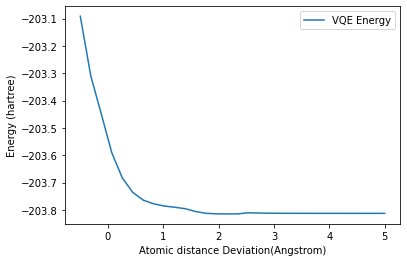

In [35]:
# Plot the energies to visualize the result
plot_energy_landscape(q1_energy_surface_result)

In [36]:
## Q2
#answer_for_ex3c_q2 = 'A'
# answer_for_ex3c_q2 = 'B'
# answer_for_ex3c_q2 = 'C'
answer_for_ex3c_q2 = 'D'
answer_for_ex3c_q2 = 'D'

In [37]:
from qc_grader import grade_ex3c

grade_ex3c(
    energy_surface=q1_energy_surface_result.energies,
    molecule=macromolecule,
    num_electrons=2,
    num_molecular_orbitals=2,
    chemistry_inspired=True,
    vqe=True,
    hardware_inspired_trial=None,
    perturbation_steps=np.linspace(-0.5, 5, 30),
    q2_multiple_choice=answer_for_ex3c_q2
)

Submitting your answer for ex3/partC. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [38]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=2)

In [39]:
true_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,  # Step 1
                                num_electrons=2,                         # Step 2a
                                num_molecular_orbitals=2,                # Step 2a
                                chemistry_inspired=True,                 # Step 3a
                                vqe=False,                               # Step 3b
                                perturbation_steps = [0])                # Step 4
plot_energy_landscape(true_total_energy)

Total Energy is:  -1.137306035753395 hartree
(No need to plot, only one configuration calculated.)


In [40]:
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=3)

quantum_calc_total_energy = construct_hamiltonian_solve_ground_state(
                                molecule=hydrogen_molecule_stretchable,           # Step 1
                                num_electrons=2,                                  # Step 2a
                                num_molecular_orbitals=2,                         # Step 2a
                                chemistry_inspired=False,                         # Step 3a
                                hardware_inspired_trial=hardware_inspired_trial,  # Step 3a
                                vqe=True,                                         # Step 3b
                                perturbation_steps = [0])                         # Step 4
plot_energy_landscape(quantum_calc_total_energy)

Total Energy is:  -1.1373050550068289 hartree
(No need to plot, only one configuration calculated.)


In [41]:
quantum_calc_total_energy.energies[0] - true_total_energy.energies[0]

9.807465661815229e-07

In [42]:
total_number_of_parameters = len(hardware_inspired_trial._ordered_parameters)
print("Total number of adjustable parameters: ", total_number_of_parameters)

Total number of adjustable parameters:  16


In [43]:
from qc_grader import grade_ex3d

## Q1
answer_for_ex3d_q1 = 'decreases'
# answer_for_ex3d_q1 = 'increases'
# answer_for_ex3d_q1 = 'stays the same'
##
answer_for_ex3d_q1 = 'decreases'

## Q2
answer_for_ex3d_q2 = 4
##

grade_ex3d(answer_for_ex3d_q1, answer_for_ex3d_q2)

Submitting your answer for ex3/partD. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


In [75]:
# Modify the following variables
num_electrons = 2;
num_molecular_orbitals = 2;
hardware_inspired_trial = TwoLocal(rotation_blocks = ['ry'], entanglement_blocks = 'cz',
                                   entanglement='linear', reps=4)

computed_macromolecule_energy_result = construct_hamiltonian_solve_ground_state(
    molecule=macromolecule,
    num_electrons=num_electrons,
    num_molecular_orbitals=num_molecular_orbitals,
    chemistry_inspired=False,
    hardware_inspired_trial=hardware_inspired_trial,
    vqe=True,
     perturbation_steps=[0])
plot_energy_landscape(quantum_calc_total_energy)

Total Energy is:  -1.1373050550068289 hartree
(No need to plot, only one configuration calculated.)


In [70]:
quantum_calc_total_energy.energies[0] - true_total_energy.energies[0]

9.807465661815229e-07

In [77]:
from qc_grader import grade_ex3e

grade_ex3e(
    energy_surface_result=computed_macromolecule_energy_result,
    molecule=macromolecule,
    num_electrons=num_electrons,
    num_molecular_orbitals=num_molecular_orbitals,
    chemistry_inspired=False,
    hardware_inspired_trial=hardware_inspired_trial,
    vqe=True,
    perturbation_steps=[0],
)

Submitting your answer for ex3/partE. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
Your score is 67.
